In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor,fidelity,tracedist,brmesolve,Qobj)
from qutip.solver import heom
from scipy.integrate import quad
from pseudomode import pseudomode,zero_temp_bath,rotation
from hamiltonians import syk_full,plot_ground,plot_fidelities,plot_trd,plot_positivity,plot_populations,plot_ground_comparison
from nmm import csolve,redfield

In [2]:
N=2
seeds=list(range(42,50))
k=0
H,psis=syk_full(N,seed=seeds[k],mu=0)

In [3]:
H

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[-0.22267004  0.          0.          0.        ]
 [ 0.          0.22267004  0.          0.        ]
 [ 0.          0.          0.22267004  0.        ]
 [ 0.          0.          0.         -0.22267004]]

In [45]:
Q=psis[0]+psis[1]#sum([(1/2 +1/(2*i+2))*psis[i] for i in range(len(psis))])
Q

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[0.        +0.j         0.70710678-0.70710678j 0.        +0.j
  0.        +0.j        ]
 [0.70710678+0.70710678j 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.70710678-0.70710678j]
 [0.        +0.j         0.        +0.j         0.70710678+0.70710678j
  0.        +0.j        ]]

In [5]:
H=20*H

In [6]:
E01=H.eigenenergies()[2]-H.eigenenergies()[0]#it is mostly degenerate, this does not help much
print(E01) 
w0=1.1 *E01#since I have no g parameter then It doesn't scale uniformingly as ising
print(w0)
gamma=w0/2.05
print(gamma)
print(2*w0>gamma)
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2)
lam=np.sqrt(Omega)
lam

8.906801743340235
9.79748191767426
4.779259472036225
True


3.082465854213903

In [7]:
state_list = [basis(2, 1)] + [-1j*basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list2 = [basis(2, 1)] + [basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list.reverse()
psi0 = (tensor(state_list)+tensor(state_list2))/np.sqrt(2)
rho0=psi0*psi0.dag()
H.dims=rho0.dims
Q.dims=rho0.dims
times=np.linspace(0,50,500)
tfit=np.linspace(0, 40, 2000)

In [8]:
bath = heom.UnderDampedBath(
        Q=Q,
        lam=lam, gamma=gamma, w0=w0, T=0, Nk=5) # fix runtime warning
cfiitter2 = heom.CorrelationFitter(
    Q, 0, tfit, bath.correlation_function)
bath1, fit2info = cfiitter2.get_fit(Ni=1, Nr=2)
# notice one mode is also a pretty good approximation
print(fit2info['summary'])

/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:925: RuntimeWarning: invalid value encountered in scalar divide
  * (1 / np.tanh(beta * (Om + 1.0j * Gamma) / 2)),
/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:927: RuntimeWarning: invalid value encountered in scalar divide
  * (1 / np.tanh(beta * (Om - 1.0j * Gamma) / 2)),


Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         | 5.17e-01 |-2.44e+00 |9.48e+00                              | 1         |-5.00e-01 |-2.39e+00 |9.50e+00                              
 2         |-9.21e-02 |-8.95e+00 |2.13e-08                              |                                                                        
                                                                        |A  normalized RM

In [9]:
times2 = np.linspace(0,40,500)
cvis = bath.correlation_function(times2)

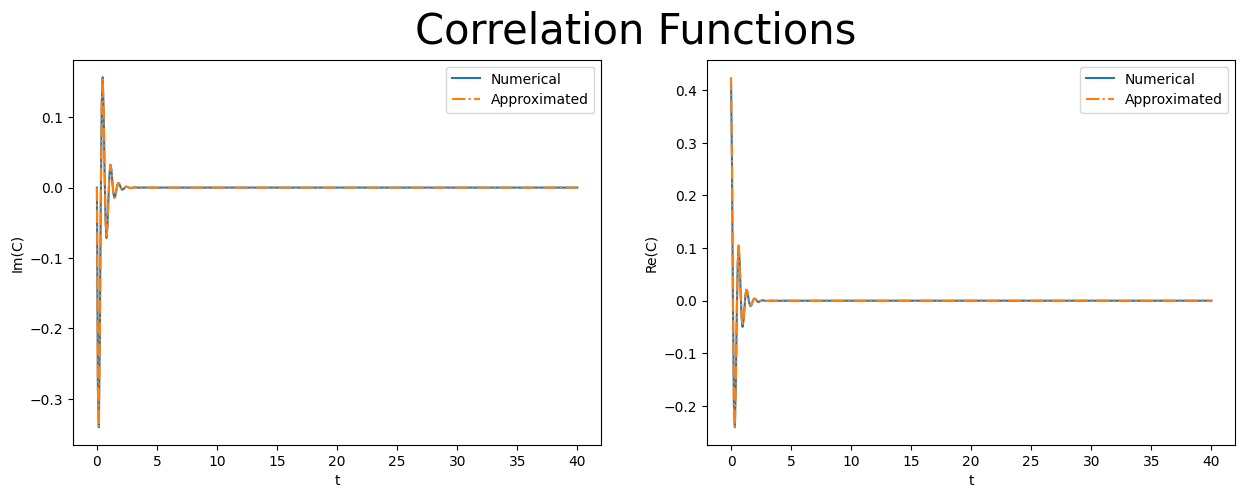

In [10]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(times2, np.imag(cvis),label="Numerical")
axs[0].plot(times2, np.imag(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(times2, np.real(cvis),label="Numerical")
axs[1].plot(times2, np.real(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [11]:
solver = heom.HEOMSolver(H,
                          [bath1], max_depth=5, options={"atol": 1e-14,"nsteps":100000})
result = solver.run(rho0, times)

10.0%. Run time:   1.80s. Est. time left: 00:00:00:16
20.0%. Run time:   3.53s. Est. time left: 00:00:00:14
30.1%. Run time:   5.23s. Est. time left: 00:00:00:12
40.1%. Run time:   6.91s. Est. time left: 00:00:00:10
50.1%. Run time:   8.59s. Est. time left: 00:00:00:08
60.1%. Run time:  10.27s. Est. time left: 00:00:00:06
70.1%. Run time:  12.26s. Est. time left: 00:00:00:05
80.2%. Run time:  14.02s. Est. time left: 00:00:00:03
90.2%. Run time:  15.77s. Est. time left: 00:00:00:01
100.0%. Run time:  17.49s. Est. time left: 00:00:00:00
Total run time:  17.49s


In [12]:
bath.bose = None
red = redfield.redfield(
    Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-4,matsubara=False)

result_red = red.evolution(rho0)

# result_red = rotation(result_red, H, times)

Started interpolation


In [13]:
result_red=[Qobj(i) for i in result_red]

In [14]:
for i in result_red:
    i.dims=H.dims

In [15]:
result_red = rotation(result_red, H, times)

In [16]:
bath.bose=None
cum = csolve(
    Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-4, cython=False)

result_cum = cum.evolution(rho0)

result_cum = rotation(result_cum, H, times)

Calculating Integrals ...: 100%|███████████████| 4/4 [00:01<00:00,  2.26it/s]
Calculating time independent matrices...: 100%|█| 4/4 [00:00<00:00, 1255.31it
Calculating time dependent generators: 100%|██| 4/4 [00:00<00:00, 179.14it/s]
Computing Exponential of Generators . . . .: 100%|█| 500/500 [00:00<00:00, 12


In [17]:
a_ops = [[Q, bath.power_spectrum]]
resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14}, sec_cutoff=-1)

a_ops = [[Q, bath.power_spectrum]]
resultBR2 = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14})

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-2.18e-02 |-2.90e+00 |7.82e-10                              | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                              
 2         |-5.51e-02 |-1.41e+01 |1.83e-09                              |                                                                        
                                                                        |A  normalized RM

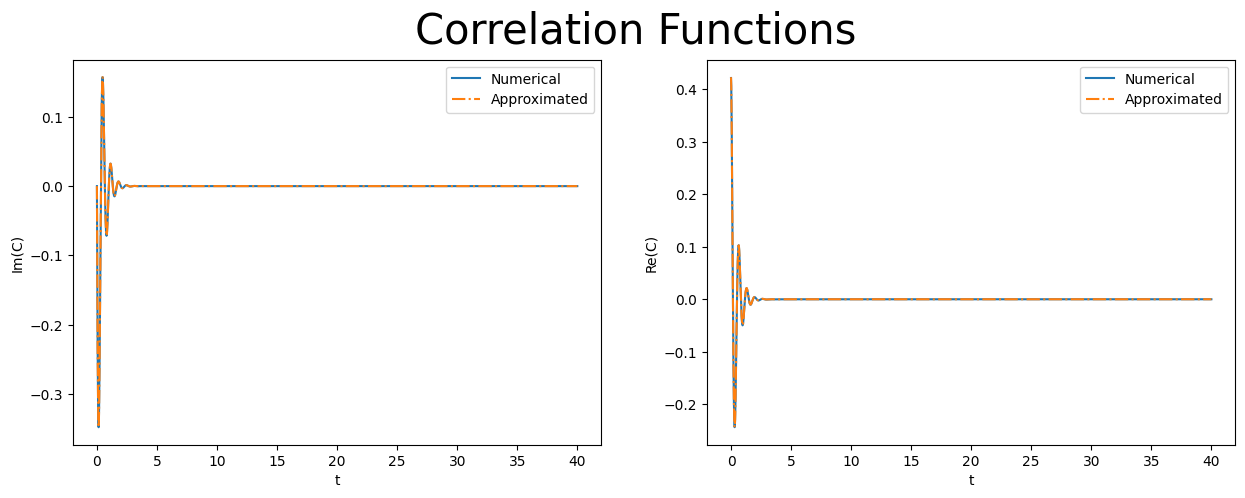

In [18]:
Ncutoff=3
modes=2
bathu = zero_temp_bath(Q, tfit, lam, gamma, w0, N=modes)
example = pseudomode(Hsys=H, Q=Q, bath=bathu)
print(bathu.finfo["summary"])
cvis2 = bathu.correlation_function
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(tfit, np.imag(cvis2),label="Numerical")
axs[0].plot(tfit, np.imag(bathu.bath.correlation_function_approx(tfit))+np.imag(bathu.C0(tfit, lam, gamma, w0)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(tfit, np.real(cvis2),label="Numerical")
axs[1].plot(tfit, np.real(bathu.bath.correlation_function_approx(tfit)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [19]:
ans = example.evolution(rho0, Ncutoff, times, options={ "normalize_output": False, "store_states": True})
ans = [i.ptrace(range(N))for i in ans.states]

In [20]:
results=[result,result_cum,resultBR,resultBR2,ans]

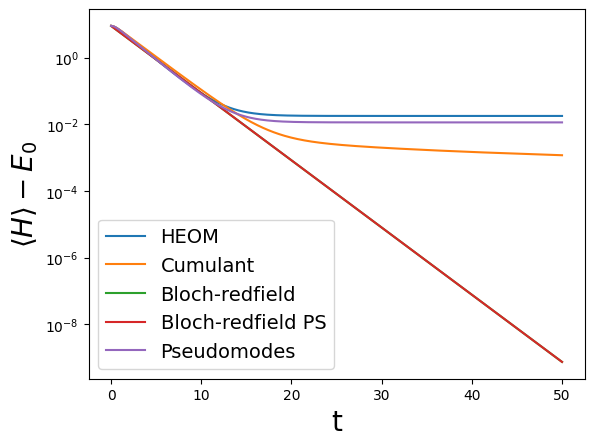

In [21]:
plot_ground(results,H,times)

In [22]:
import numpy as np
from scipy.linalg import expm
# compute the Bloch-Redfield tensor in the Hamiltonian's basis
def BR_tensor(H, a_ops, secular = True, secular_cut_off = 0.01):
    dim = len(H) # dimension
    evals,ekets = np.linalg.eig(H) # HS's basis
    # sort basis
    _zipped = list(zip(evals, range(len(evals))))
    _zipped.sort()
    evals, perm = list(zip(*_zipped))
    ekets = np.array([ekets[:, k] for k in perm])
    evals = np.array(evals)
    # coupling operators in H basis
    a_ops_S = [[ekets.conjugate()@a@ekets.T,nps] for a,nps in a_ops] 
    # Bohr frequencies (w_ab)
    indices = [(a,b) for a in range(dim) for b in range(dim)]
    BohrF = np.sort(np.array([evals[a]-evals[b] for a in range(dim) for b in range(dim)]))
    # construct empty R
    R = np.zeros((dim**2,dim**2),dtype = complex) 
    for j,(a,b) in enumerate(indices): # loop over indices
        for k,(c,d) in enumerate(indices): # loop over indices
            # unitary part
            R[j,k] += -1j * (a==c)*(b==d)*(evals[a]-evals[b])
            for a_op,nps in a_ops_S: # loop over uncorrelated a_ops
                gmax = np.max([bath.power_spectrum(f) for f in BohrF]) # largest rate for secular approximation
                A = a_op # coupling operator
                # secular approximation test
                if secular is True and abs(evals[a]-evals[b]-evals[c]+evals[d]) > gmax*secular_cut_off:
                    pass
                else:      
                    # non-unitary part
                    R[j,k] += - 1/2 * ((b==d)*np.sum([A[a,n]*A[n,c]*nps(evals[c]-evals[n])  
                                                      for n in range(dim)])
                                                     -A[a,c]*A[d,b]*nps(evals[c]-evals[a]) +
                                       (a==c)*np.sum([A[d,n]*A[n,b]*nps(evals[d]-evals[n])  
                                                      for n in range(dim)])
                                                     -A[a,c]*A[d,b]*nps(evals[d]-evals[b]))
    return R

In [23]:
# Hamiltonian eigendecomposition
evals,ekets = np.linalg.eig(H.full()) # HS's basis
# sort basis
_zipped = list(zip(evals, range(len(evals))))
_zipped.sort()
evals, perm = list(zip(*_zipped))
ekets = np.array([ekets[:, k] for k in perm])
evals = np.array(evals)


# coupling operators and associated noise power spectra
a_ops = [[Q.full(),lambda w: bath.power_spectrum(-w)]]

# Bloch-Redfield tensor in H basis
R = BR_tensor(H.full(), a_ops,secular=False)

/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:445: ComplexWarning: Casting complex values to real discards the imaginary part
  w = np.array(w, dtype=float)


In [24]:
from scipy.integrate import solve_ivp

In [25]:
def f(t, y):
    return R @ y
rho_vec=rho0.full().flatten()
resultbbr = solve_ivp(f, [0, times[-1]],rho_vec,t_eval=times, method="BDF")
n = H.shape[0]
result_br= [Qobj(resultbbr.y[:, i].reshape(n, n))
          for i in range(len(times))]


In [26]:
rho0

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0.5+0.j  0. -0.5j 0. +0.j ]
 [0. +0.j  0. +0.5j 0.5+0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]]

In [27]:
for i in result_br:
    i.dims=H.dims

In [29]:
results=[result,result_cum,resultBR,resultBR2,ans,result_red]

In [30]:
def plot_fidelities(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Redfield","BR","Global"]
    style=["solid","solid","dashed","dashdot",'dashed',"solid","dashed","dashdot"]
    for k,i in enumerate(states[1:],1):
        if "Bloch" in  labels[k]:
            sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
        else:
            try:
                sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
            except:
                sdd=np.array([fidelity(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$\mathcal{F}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

In [31]:
global_one=cum.jump_operators(Q) # Global Jump Operators for Bath 1 2->4
c_ops2=[Qobj((np.sqrt(bath.power_spectrum(k))*v).data) for k, v in global_one.items()]
for i in range(len(c_ops2)):
    c_ops2[i].dims=H.dims 
result_lindblad_global= mesolve(H, rho0, times, c_ops2)

In [32]:
all_energy, all_state = H.eigenstates()

Nmax = len(all_state)



collapse_list = []

for j in range(Nmax):

    for k in range(j+1,Nmax):
        Deltajk = abs(all_energy[k] - all_energy[j])
        if abs(Deltajk) > 0 :   #this is basically s(w) = 2 J(w) * (n+1) * matrix element 
            rate = np.absolute(Q.matrix_element(all_state[j].dag(),all_state[k]))**2 * bath.power_spectrum(Deltajk)
            if rate > 0.0:
                collapse_list.append((np.sqrt(rate)*all_state[j]*all_state[k].dag()))  #emission

            #this is basically s(w) = 2 J(w) * (n) * matrix element 
            rate = np.absolute(Q.matrix_element(all_state[k].dag(),all_state[j]))**2 * 2  * bath.power_spectrum(-Deltajk)
            if rate > 0.0: 
                collapse_list.append((np.sqrt(rate)*all_state[k]*all_state[j].dag())) #absorption

    for j in range(Nmax):
        #this is basically s(0), which can be non-zero at T!=0
        rate = np.absolute(Q.matrix_element(all_state[j].dag(),all_state[j]))**2 * bath.power_spectrum(0)
        if rate > 0.0:
            collapse_list.append((np.sqrt(rate)*all_state[j]*all_state[j].dag()))  #emission

In [33]:
outputBMS = mesolve(H, rho0, times, collapse_list)

In [34]:
results=[result,result_cum,resultBR,resultBR2,ans,result_red,outputBMS,result_lindblad_global]

In [39]:
def plot_fidelities(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Redfield","Global"]
    style=["solid","solid","dashed","dashdot",'dashed',"solid","dashed","dashdot"]
    for k,i in enumerate(states[1:],1):
        if "Bloch" in  labels[k]:
            sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
        else:
            try:
                sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
            except:
                sdd=np.array([fidelity(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$\mathcal{F}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

In [40]:
results=[result,result_cum,resultBR,resultBR2,result_red,result_lindblad_global]

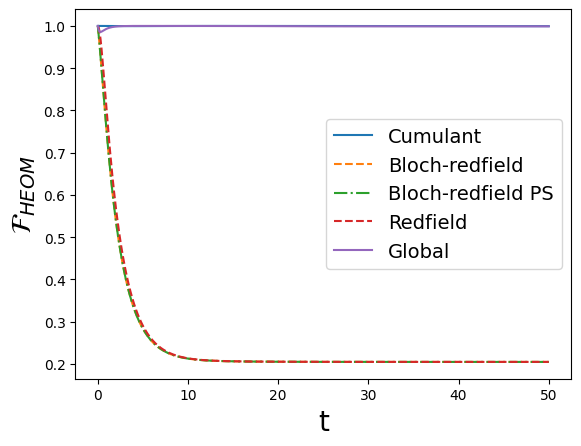

In [41]:
plot_fidelities(results,H,times)

In [48]:
def plot_ground_comparison(H,results):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Redfield","Global"]
    style=["solid","dotted","dashed","dashdot",'dotted',"solid"]
    fig, axs = plt.subplots(1, 3,figsize=(25,5))
    rho00=(H.eigenstates()[1][0]* H.eigenstates()[1][0].dag())/(H.eigenstates()[1][0]* H.eigenstates()[1][0].dag()).tr()
    rho01=(H.eigenstates()[1][1]* H.eigenstates()[1][1].dag())/(H.eigenstates()[1][1]* H.eigenstates()[1][1].dag()).tr()
    ground=(rho01+rho00)/2
    t=results[0].times
    for k,result in enumerate(results):
        if "Bloch" in  labels[k]:
            f=[fidelity(result.states[i].conj(),rho00) for i in range(len(results[0].states))]
            f2=[fidelity(result.states[i].conj(),rho01) for i in range(len(results[0].states))]
            f3=[fidelity(result.states[i].conj(),ground) for i in range(len(results[0].states))]
        try:
            f=[fidelity(result.states[i],rho00) for i in range(len(results[0].states))]
            f2=[fidelity(result.states[i],rho01) for i in range(len(results[0].states))]
            f3=[fidelity(result.states[i],ground) for i in range(len(results[0].states))]
        except:
            f=[fidelity(result[i],rho00) for i in range(len(results[0].states))]
            f2=[fidelity(result[i],rho01) for i in range(len(results[0].states))]
            f3=[fidelity(result[i],ground) for i in range(len(results[0].states))]
        axs[0].plot(t, f,label=labels[k],linestyle=style[k])
        axs[1].plot(t, f2,label=labels[k],linestyle=style[k])
        axs[2].plot(t, f3,label=labels[k],linestyle=style[k])

    axs[0].set_xlabel("t")
    axs[0].set_ylabel(r"$\mathcal{F}_{ground_{1}}$",fontsize=20)
    axs[1].set_xlabel("t")
    axs[1].set_ylabel(r"$\mathcal{F}_{ground_{2}}$",fontsize=20)
    axs[0].set_xlabel("t")
    axs[2].set_ylabel(r"$\mathcal{F}_{ground}$",fontsize=20)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    fig.suptitle('Fidelity to the ground state', fontsize=30)
    plt.show()

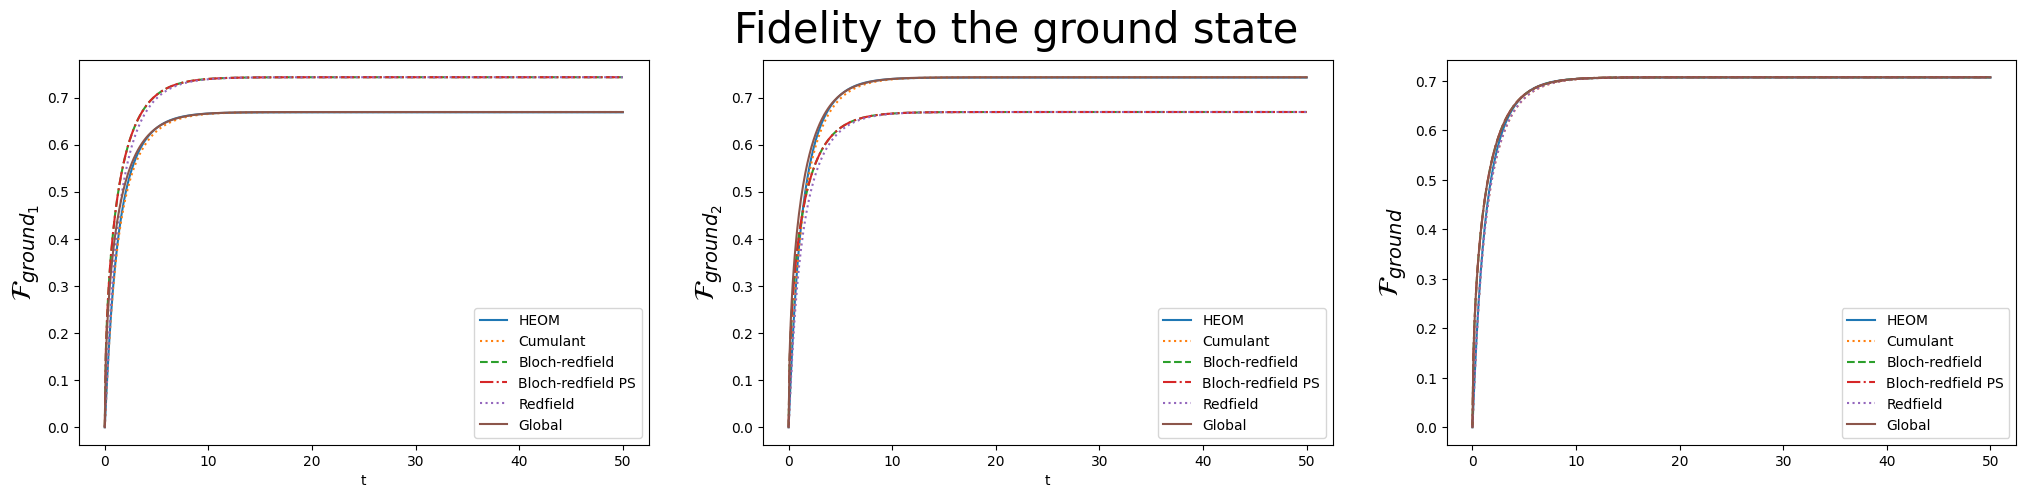

In [49]:
plot_ground_comparison(H, results)

In [ ]:
result_br[-400]

In [50]:
resultBR2.states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[5.52136133e-01+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 4.86603910e-01+1.02461984e-01j]
 [0.00000000e+00+0.00000000e+00j 4.18441942e-11+0.00000000e+00j
  0.00000000e+00-4.18441942e-11j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+4.18441942e-11j
  4.18441942e-11+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [4.86603910e-01-1.02461984e-01j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 4.47863867e-01+0.00000000e+00j]]

In [51]:
results[0].states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[ 4.46970131e-01-2.85347610e-17j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -4.85632867e-01+1.02257516e-01j]
 [ 0.00000000e+00+0.00000000e+00j  9.97776030e-04+3.38199577e-18j
   5.87035145e-18-9.97776030e-04j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  4.90379341e-17+9.97776030e-04j
   9.97776030e-04+1.56981049e-17j  0.00000000e+00+0.00000000e+00j]
 [-4.85632867e-01-1.02257516e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  5.51034317e-01-4.26698755e-18j]]

In [ ]:
results[1][-1]

In [ ]:
results[3].states[-1]

In [ ]:
f=np.array([ fidelity(resultBR.states[k],state) for k,state in enumerate(result.states)])
fcon=np.array([ fidelity(resultBR.states[k].trans(),state) for k,state in enumerate(result.states)])

In [ ]:
plt.plot(times,f,label="No conjugate")
plt.plot(times,fcon,label="conjugate")
plt.legend()

In [ ]:
plot_trd(results,H,times)

In [ ]:
plot_fidelities(results,H,times)

In [ ]:
plot_positivity(results,H,times)

In [ ]:
resultBR.states[2]

In [ ]:
result.states[2]

In [ ]:
plot_populations(results,H,times,l=0,m=0)

In [ ]:
from qutip import qsave,qload

In [ ]:
#qsave(results,f"N={N}_syk_{lam}_mulcheating_seed_{seeds[k]}")

In [ ]:
plot_ground_comparison(H,results)